In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def getTheDistrAsList(series):
    return [val for val in series if not np.isnan(val)]

def log_likelihood(pmfs, data):
    """
    Compute the log-likelihood function for a discrete distribution
    
    Parameters:
        pmfs (list of functions): Probability mass functions of the distributions.
        data (array-like): Observed data.
        
    Returns:
        float: Log-likelihood value.
    """
    # Initialize log-likelihood
    log_likelihood_value = 0.0
    #Add pseudo count to pmfs
    pmfs = np.array(pmfs) + 10**-10
    pmfs = pmfs / np.sum(pmfs)

    # Compute the log-likelihood
    for datum in data:
        log_likelihood_value += np.log(pmfs[datum])

    return log_likelihood_value

def colorSelection(lista, listaColor, colorTBS):
    #Keep the elements in lista whose color is in colorTBS
    return [lista[i] for i, color in enumerate(listaColor) if color in colorTBS]

In [3]:
columnsTBImported = ['SubjID', 'TrialID', 'Level', 'DepthID', 'N_REWARDS', "TOTAL_TIME", "VIEW_TIME", "SOL_LENGHT", "N_BACKTRACK", "Color", "SUCCESSFUL"]
df = pd.read_csv("SynopticDataframe.csv", usecols=columnsTBImported)

########################
## INCLUSION CRITERIA ##
########################
cond0 = df["Level"]<4
cond1 = df["Level"]>0 
cond2 = df["TOTAL_TIME"] > 0 
cond2bis = df["VIEW_TIME"] > 0
cond3 = df["SOL_LENGHT"] > 0
cond4 = df["N_BACKTRACK"] < 30
df_red = df[cond0 & cond1 & cond2 & cond2bis & cond3 & cond4].reset_index(drop = True)
df_red = df_red.groupby("SubjID").filter(lambda x: len(x)>80).reset_index()

## SUPPLEMENTARY FIGURES:S4

In [7]:
heatmapList = []
for COLOR in [0,1]:
    # Import old Rdf.csv
    # Load the old Rdf.csv file into a pandas DataFrame
    Rdf = pd.read_csv("Rdf.csv")

    # Find and remove trial problems that are not in Rdf.TrialID
    # Load the problem list from a text file
    problemList = list(np.loadtxt("./problemList.txt", dtype=str))
    problemListOriginal = list(np.loadtxt("./problemList.txt", dtype=str))
    indexesToRemove = []

    # Loop through each problem in problemList
    for i, problem in enumerate(problemList):
        # Check if the problem (without the last 10 characters) is not in Rdf.TrialID
        if problem[:-10] not in Rdf.TrialID.unique():
            indexesToRemove.append(i)

    # Remove the problems at the identified indexes
    problemList = [problemList[i] for i in range(len(problemList)) if i not in indexesToRemove]

    # Initialize a new DataFrame RdfV2
    RdfV2 = pd.DataFrame()
    RdfV2["TrialID"] = Rdf.TrialID.unique()

    # Populate RdfV2 with data from Rdf
    RdfV2["N_REWARDS"] = [Rdf.loc[Rdf.TrialID == TrialID, "N_REWARDS"].values[0] for TrialID in RdfV2.TrialID]
    RdfV2["Reward_BeforeBacktrack"] = [Rdf.loc[Rdf.TrialID == TrialID, "R_BB"].values[0] for TrialID in RdfV2.TrialID]
    RdfV2["Reward_BeforeBacktrack"] = RdfV2["Reward_BeforeBacktrack"].apply(lambda x: [int(n) for n in x[1:-1].split(", ")])
    RdfV2["SubjID"] = [Rdf.loc[Rdf.TrialID == TrialID, "SubjID"].values[0] for TrialID in RdfV2.TrialID]
    RdfV2["SubjID"] = RdfV2["SubjID"].apply(lambda x: x[1:-1].split(", ")).apply(lambda x: [n[1:-1] for n in x])

    # Initialize an empty Series to store color information
    ColorSeries = pd.Series()

    # Loop through each unique TrialID in RdfV2
    for TrialID in RdfV2.TrialID.unique():
        colorLs = []
        for SubjID in RdfV2.loc[RdfV2.TrialID == TrialID, "SubjID"].values[0]:
            # Get the color of the trial from df_red DataFrame
            color = df_red.loc[(df_red.TrialID == TrialID) & (df_red.SubjID == SubjID), "Color"].values[0]
            colorLs.append(color)
        ColorSeries[TrialID] = colorLs

    # Assign the color information to RdfV2
    RdfV2["Color"] = RdfV2["TrialID"].apply(lambda x: ColorSeries[x])

    # Apply the color selection function to the Reward_BeforeBacktrack column
    RdfV2["Reward_BeforeBacktrack"] = RdfV2.apply(lambda x: colorSelection(x["Reward_BeforeBacktrack"], x["Color"], [COLOR]), axis=1)

    # Import performance data of different models
    epsilon = 0.0
    BETALs = [100.]
    IT_MAX = 500

    columnNamesFORWARD = []
    PDs = []

    # Loop through each depth from 1 to 8
    for depth in range(1, 9):
        BETA = BETALs[0]
        columnName = f"PD_FORWARD{depth}Epsilon{epsilon}BETA{BETA}ITMAX{IT_MAX}"
        columnNamesFORWARD.append(columnName)
        
        # Read the corresponding PD file for the current depth
        PD = pd.read_csv(f"./PD_V18/PD_NO_BACKWARD_{depth}Epsilon{epsilon}BETA{BETA}ITMAX{IT_MAX}.csv", index_col=0)
        
        # Drop the rows at the indexes to be removed
        PD = PD.drop(indexesToRemove)
        
        # Reset the indexes of the DataFrame
        PD = PD.reset_index(drop=True)
        
        # Drop the 'Unnamed: 0.1' column if it exists
        if "Unnamed: 0.1" in PD.columns:
            PD = PD.drop(columns=["Unnamed: 0.1"])
        
        # Append the cleaned PD DataFrame to the list PDs
        PDs.append(PD)
        
        # Apply the getTheDistrAsList function to each row and assign to RdfV2
        RdfV2[columnName] = PD.apply(lambda x: getTheDistrAsList(x), axis=1)

    # Get the minimum depth for each trial for this model
    nonNull = []
    for TrialIndex in range(90):
        N_REWARDS = RdfV2.loc[TrialIndex, "N_REWARDS"]
        nonNull += [np.min([depth for depth in range(1, N_REWARDS + 1) if PDs[depth - 1].loc[TrialIndex, str(N_REWARDS)] > 0])]

    # Create a dictionary mapping problem to its minimum depth
    nonNullDict = {problem[:-10]: nonNull[i] for i, problem in enumerate(problemList)}

    # Create a DataFrame with the minimum depth for each trial
    minDepth = pd.DataFrame()
    minDepth["TrialID"] = RdfV2.TrialID
    minDepth["minDepth"] = nonNull

    # Add the minimum depth to the RdfV2 DataFrame
    RdfV2["MinAgentFORWARD"] = minDepth["minDepth"]

    # Calculate log likelihood for each model and add to RdfV2
    for columnName in columnNamesFORWARD:
        RdfV2[columnName + "LL"] = RdfV2.apply(lambda x: log_likelihood(x[columnName], x["Reward_BeforeBacktrack"]), axis=1)

    Rdf = RdfV2
    # Find the best model for each trial based on log likelihood
    for TrialID in Rdf.TrialID.unique():
        columnNamesLLFORWARD = [columnName + "LL" for columnName in columnNamesFORWARD]
        Rdf.loc[(Rdf.TrialID == TrialID), "BestModelFORWARD"] = Rdf.loc[Rdf.TrialID == TrialID, columnNamesLLFORWARD].idxmax(axis=1).values[0]

    # Extract the best depth for each trial
    Rdf["BestDepthFORWARD"] = Rdf["BestModelFORWARD"].apply(lambda x: x[10] if x is not None else None)

    # Generate a heatmap for the best depth for each trial
    heatmap = []
    for depth in range(1, Rdf["N_REWARDS"].max() + 1):
        myarray = Rdf[Rdf.MinAgentFORWARD == depth].BestDepthFORWARD.values.astype(int)
        weights = np.ones_like(myarray) / float(len(myarray))
        heatmap.append(
            np.histogram(myarray, weights=weights, range=(0.5, Rdf["N_REWARDS"].max() + .5), bins=Rdf["N_REWARDS"].max())[0]
        )
    heatmapList.append(heatmap)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


In [8]:
heatmap0 = heatmapList[0]
heatmap1 = heatmapList[1]
difference = np.array(heatmap1)-np.array(heatmap0)

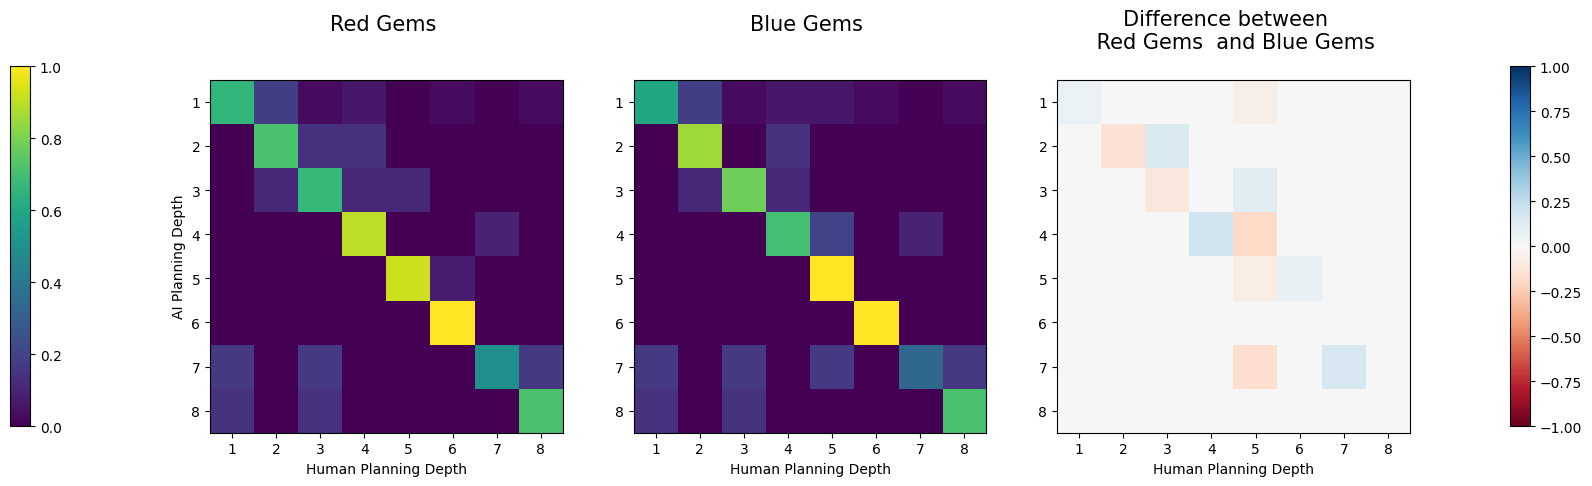

In [9]:
fig, axs = plt.subplots(nrows = 1, ncols=3, figsize = (20,20))
im = axs[0].imshow(heatmap1, vmin =0, vmax = 1, cmap = "viridis")
axs[0].set_xticks(range(0,8), range(1,9))
axs[0].set_yticks(range(0,8), range(1,9))
#plt.ylabel("Minimal Solving Depth")
axs[0].set_ylabel("AI Planning Depth")
#plt.xlabel("Most Similar Solving Depth")
axs[0].set_xlabel("Human Planning Depth")


axs[1].imshow(heatmap0, vmin = 0, vmax = 1, cmap = "viridis")
axs[1].set_xticks(range(0,8), range(1,9))
axs[1].set_yticks(range(0,8), range(1,9))
#plt.ylabel("Minimal Solving Depth")
axs[1].set_ylabel("")
#plt.xlabel("Most Similar Solving Depth")
axs[1].set_xlabel("Human Planning Depth")

imdiff = axs[2].imshow(difference, vmin = -1, vmax = 1, cmap = "RdBu")
axs[2].set_xticks(range(0,8), range(1,9))
axs[2].set_yticks(range(0,8), range(1,9))
#plt.ylabel("Minimal Solving Depth")
axs[2].set_ylabel("")
#plt2xlabel("Most Similar Solving Depth")
axs[2].set_xlabel("Human Planning Depth")
#plt.title("")
#plt.sca(axs[2])

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.41, 0.01, 0.18])
fig.colorbar(imdiff, cax = cbar_ax)

fig.subplots_adjust(left=0.2)
cbar_ax = fig.add_axes([0.1, 0.41, 0.01, 0.18])
fig.colorbar(im, cbar_ax)

plt.text(x = 16,y = 1.1, s = "Red Gems", fontsize=15)
plt.text(x = 37,y = 1.1, s = "Blue Gems", fontsize=15)
plt.text(x = 54,y = 1.05, s = "     Difference between \n Red Gems  and Blue Gems", fontsize=15)

#plt.savefig("IMAGES/FigureS4.png", dpi = 144, facecolor = "w")

plt.show()